In [51]:
device = "cpu"
import os,torch,pytorch_spiking,time
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pennylane as qml
from tqdm import tqdm
from pennylane import numpy as np
torch.manual_seed(0)
np.random.seed(0)
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = "16"

In [52]:
data_path = './raw/'  # ta" if torch.cuda.is_available() else "cpu")
batch = 100
device = torch.device("cpu" if torch.cuda.is_available() else "cuda")
train_dataset = torchvision.datasets.FashionMNIST(root=data_path, train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=0)

test_set = torchvision.datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False, num_workers=0)

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(class_names)

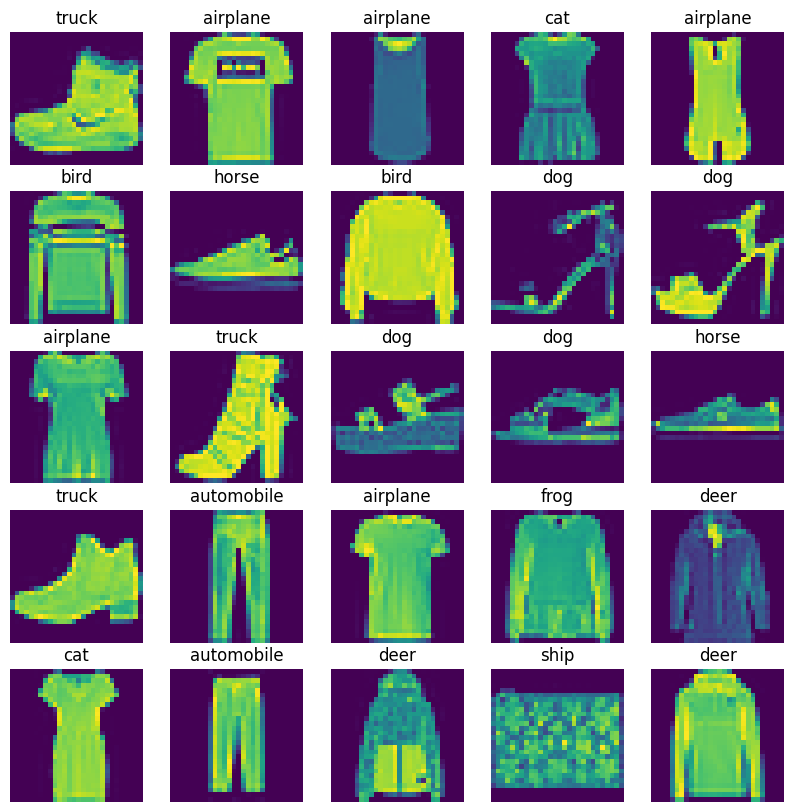

In [53]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].transpose(1, 2, 0), interpolation='none')
    plt.axis("off")
    plt.title(class_names[train_labels[i]])                 

In [54]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),       
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True,dt=0.01),     
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),      
    torch.nn.Linear(128, 10),      
)

In [55]:
#define quantum parameters
n_qubits = 5         
nqubits=n_qubits
batch_size = 4              
num_epochs = 1           
q_depth = 2            
q_delta = 0.01              
start_time = time.time()    
tensor_length = n_qubits*(n_qubits-1)*q_depth+n_qubits

In [56]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RZ_layer(w):
    for idx, element in enumerate(w):   
        qml.RZ(element, wires=idx)      

def RY_layer(w):
    for idx, element in enumerate(w):   
        qml.RY(element, wires=idx)   

def RX_layer(w):
    for idx, element in enumerate(w):  
        qml.RX(element, wires=idx)  
                
def entangling_layer(nqubits,weights):
    p = nqubits
    weights_ = (weight for weight in weights)   
    for i in range(1,nqubits):

        qml.CNOT(wires=[0,i])
        param = next(weights_)      

        qml.RZ(param, wires=i)
        p+=1   
        param = next(weights_)

        qml.RX(param, wires=i)
        p+=1                       
        param = next(weights_)

        qml.RZ(param, wires=i)
        p+=1   

        qml.CNOT(wires=[0,i])

In [57]:
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")

def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat
    
    H_layer(n_qubits)


    RY_layer(q_input_features)
    entangling_layer(nqubits,q_weights)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]      

    return tuple(exp_vals)    
    
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(128, n_qubits)      
        self.q_params = nn.Parameter(q_delta * torch.randn(tensor_length))       
        self.post_net = nn.Linear(n_qubits, 10)       

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)       
        q_in = torch.tanh(pre_out) * np.pi / 2.0     
        q_out = torch.Tensor(0, n_qubits)      
        q_out = q_out.to(device)               
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)    
            q_out = torch.cat((q_out, q_out_elem))    

        return self.post_net(q_out)      

print(qml.draw(quantum_net)([0,0,0,0,0],np.random.rand(tensor_length)))

0: ──H──RY(0.00)─╭●───────────────────────────────╭●─╭●───────────────────────────────╭●─╭●
1: ──H──RY(0.00)─╰X──RZ(0.55)──RX(0.72)──RZ(0.60)─╰X─│────────────────────────────────│──│─
2: ──H──RY(0.00)─────────────────────────────────────╰X──RZ(0.54)──RX(0.42)──RZ(0.65)─╰X─│─
3: ──H──RY(0.00)─────────────────────────────────────────────────────────────────────────╰X
4: ──H──RY(0.00)───────────────────────────────────────────────────────────────────────────

────────────────────────────────╭●─╭●───────────────────────────────╭●─┤  <Z>
────────────────────────────────│──│────────────────────────────────│──┤  <Z>
────────────────────────────────│──│────────────────────────────────│──┤  <Z>
───RZ(0.44)──RX(0.89)──RZ(0.96)─╰X─│────────────────────────────────│──┤  <Z>
───────────────────────────────────╰X──RZ(0.38)──RX(0.79)──RZ(0.53)─╰X─┤  <Z>


In [58]:
quantum_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),      
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True,dt=0.01),     
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),      
    torch.nn.Linear(128, 128),       
)
quantum_model.fc = DressedQuantumNet()  

In [59]:
def net(input_model, q_input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adam(input_model.parameters())   
    optimizer = torch.optim.Adam(q_input_model.parameters())

    input_model.train()
    q_input_model.train()

    for j in range(101):
        train_acc = 0
        loss_acc = 0
        #cm = np.zeros((10, 10), dtype=np.int32)
        for i in tqdm(range(train_x.shape[0] // minibatch_size)):     
            input_model.zero_grad()    
            q_input_model.zero_grad()

            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]   
            # flatten images
            #batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            s_out = input_model(torch.tensor(batch_in))     
            q_out = q_input_model(torch.tensor(batch_in))
            output = s_out*0.2 + q_out*0.8
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            #batch_label = batch_label.astype(np.int64)         
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))  
            loss = -logpy.mean()    
            loss_acc += loss 
            loss.backward()   
            optimizer.step()
            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()   
            )
        train_acc /= i + 1
        print("Train accuracy (%d): " % j, train_acc.numpy())    
        loss_acc /=i + 1
        print("Loss (%d): " % j, loss_acc.detach().numpy())
        # compute test accuracy
        input_model.eval()                             
        q_input_model.eval()

    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        s_out = input_model(torch.tensor(batch_in))     
        q_out = q_input_model(torch.tensor(batch_in))
        output = s_out*0.2 + q_out*0.8
        test_acc += torch.mean(torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float())
        test_acc /= i + 1
        print("Test accuracy:", test_acc.numpy())

In [60]:
net(spiking_model, quantum_model, train_sequences, test_sequences)

  0%|          | 0/375 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (896x28 and 784x128)